In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [20]:
trial_data = pd.read_csv('data/trial_data.csv')

In [21]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
text = "This is my text. It icludes commas, question marks? and other stuff. Also U.S.."
tokens = tokenizer.tokenize(text)
print(tokens)

['This', 'is', 'my', 'text', 'It', 'icludes', 'commas', 'question', 'marks', 'and', 'other', 'stuff', 'Also', 'U', 'S']


In [22]:
trial_data['words'] = trial_data['transcript'].apply(tokenizer.tokenize)


<AxesSubplot:>

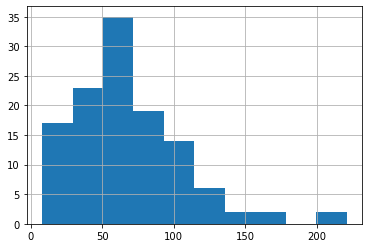

In [23]:
trial_data['word_count_nltk'] = trial_data['words'].apply(len)
trial_data['word_count_nltk'].hist()

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_sentiment = SentimentIntensityAnalyzer()

In [8]:
full_sent = trial_data['transcript'].apply(lambda x: nltk_sentiment.polarity_scores(x))
full_sent.head()

0    {'neg': 0.398, 'neu': 0.602, 'pos': 0.0, 'comp...
1    {'neg': 0.012, 'neu': 0.965, 'pos': 0.024, 'co...
2    {'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'comp...
3    {'neg': 0.154, 'neu': 0.8, 'pos': 0.046, 'comp...
4    {'neg': 0.145, 'neu': 0.749, 'pos': 0.106, 'co...
Name: transcript, dtype: object

In [9]:
# store the compound sentiment in a column
trial_data['sentiment'] = full_sent.apply(lambda x: x['compound'])
print(trial_data['sentiment'].head())

0   -0.6808
1    0.3612
2   -0.2960
3   -0.6964
4   -0.8829
Name: sentiment, dtype: float64


<AxesSubplot:>

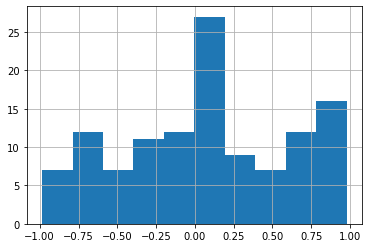

In [10]:
trial_data['sentiment'].hist()

In [11]:
pred_vars = ['word_count_nltk', 'sentiment']

# define the dependent variable
outcome = 'condition'

# Train/test split

In [12]:
np.random.seed(516)

# create train and test
train, test = train_test_split(trial_data, test_size=0.20, stratify=trial_data[outcome])
print("Rows in train:", len(train))
print("Rows in test:", len(test))

Rows in train: 96
Rows in test: 24


# Fit Classifiers

In [13]:
#%% random forest
from sklearn.ensemble import RandomForestClassifier

params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, None]}

rf_tuned = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc')
rf_tuned.fit(train[pred_vars], train[outcome])


#%% Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier

params = {'hidden_layer_sizes': [(100,), (10,10), (5,5,5)], 
          'solver': ['adam', 'lbfgs', 'sgd']}

nnet_tuned = GridSearchCV(MLPClassifier(), param_grid=params, scoring='roc_auc')
nnet_tuned.fit(train[pred_vars], train[outcome])

#%% adaboost
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier

params = {'n_estimators': [10, 25, 50]}

ada_tuned = GridSearchCV(AdaBoostClassifier(), param_grid=params, scoring='roc_auc')
ada_tuned.fit(train[pred_vars], train[outcome])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [10, 25, 50]}, scoring='roc_auc')

# Evaluate with Hold-Out Data

RandomForestClassifier()
MLPClassifier()
AdaBoostClassifier()


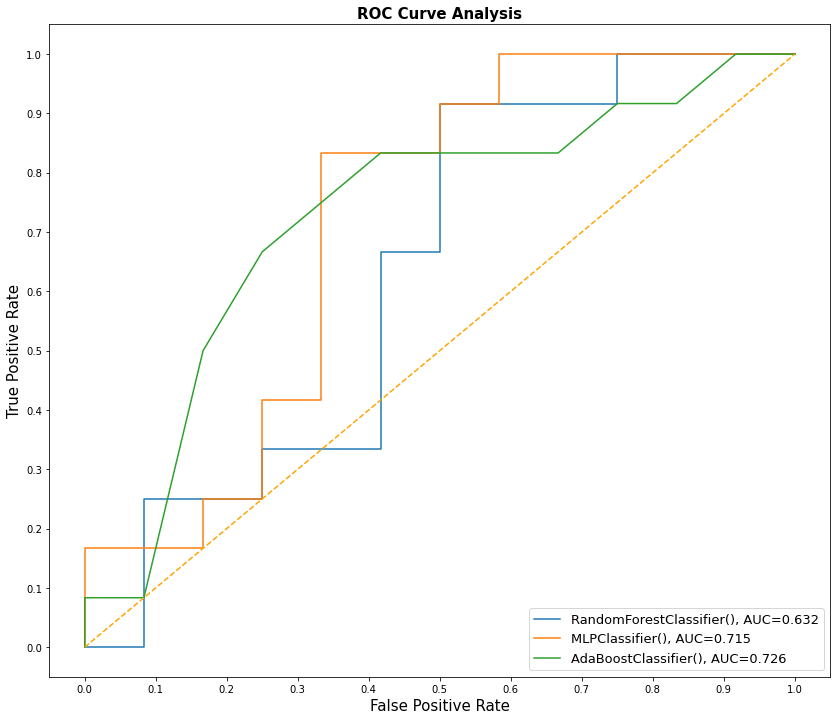

In [14]:
from sklearn import metrics

fitted = [rf_tuned, nnet_tuned, ada_tuned]

result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    print(clf.estimator)
    yproba = clf.predict_proba(test[pred_vars])
    yclass = clf.predict(test[pred_vars])
    
    # auc information
    """
    Note that I specified the positve case here as 'truth'
    since that is what we are trying to detect. Otherwise,
    this line will present an error, since the classes are not
    0 or 1, but categorical labels.
    """
    fpr, tpr, _ = metrics.roc_curve(test[outcome],  yproba[:,1], pos_label='truth')
    auc = metrics.roc_auc_score(test[outcome], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test[outcome], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test[outcome], yclass)
    
    
    result_table = result_table.append({'classifier_name':str(clf.estimator),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)
    


result_table.set_index('classifier_name', inplace=True)
# print(result_table)



fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Confusion Matrix Stats

In [15]:
for i in result_table.index:
    print('\n---- statistics for', i, "----\n")
    print(result_table.loc[i, 'clf_report'])
    print("Model log loss:", result_table.loc[i, 'log_loss'])


---- statistics for RandomForestClassifier() ----

              precision    recall  f1-score   support

         lie       0.64      0.58      0.61        12
       truth       0.62      0.67      0.64        12

    accuracy                           0.62        24
   macro avg       0.63      0.62      0.62        24
weighted avg       0.63      0.62      0.62        24

Model log loss: 0.6491924167693696

---- statistics for MLPClassifier() ----

              precision    recall  f1-score   support

         lie       1.00      0.42      0.59        12
       truth       0.63      1.00      0.77        12

    accuracy                           0.71        24
   macro avg       0.82      0.71      0.68        24
weighted avg       0.82      0.71      0.68        24

Model log loss: 0.6705992425840099

---- statistics for AdaBoostClassifier() ----

              precision    recall  f1-score   support

         lie       0.69      0.75      0.72        12
       truth       0.73 

# Tasks

1. Name at least three limitations of this data.
    
2. From the results above, which model would you say performed best?


# Extra Tasks

With text analysis, the variables that you can construct are only limited by your imagination. Try computing another measure and see if that improves the prediction results. For example, you might try to count the number of times a transcription contains the use of "I".

# Task 1 

Name at least three limitations of this data.

1. First limitation is the size of the data set. We only had 96 rows to train the data and 24 to test on. This is a very small sample size to trust results from.

2. The second limitation of setiment analysis is computers can not take into consideration context. Something such as sarcasm could throw the analysis off.

3. The third limitation is it could be possible that a statement could contain a lie and a truth. I am unaware of how this data set handles this possible.

# Task 2

From the results above, which model would you say performed best?

The AdaBoostClassifier Model performed the best. AdaBoostClassifier had the best performing Area under the curve and log loss. While it acheived the same accuracy as the MLP Classifier. The only scenario where I would reconmend MLP over Ada Boost is if getting Truth right took priority over everything else, this is due to the recall of 1.00.

# Extra Tasks

With text analysis, the variables that you can construct are only limited by your imagination. Try computing another measure and see if that improves the prediction results. For example, you might try to count the number of times a transcription contains the use of "I".

In [31]:
trial_data = pd.read_csv('data/trial_data.csv')

In [32]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
text = "This is my text. It icludes commas, question marks? and other stuff. Also U.S.."
tokens = tokenizer.tokenize(text)
print(tokens)

['This', 'is', 'my', 'text', 'It', 'icludes', 'commas', 'question', 'marks', 'and', 'other', 'stuff', 'Also', 'U', 'S']


In [33]:
trial_data['words'] = trial_data['transcript'].apply(tokenizer.tokenize)

<AxesSubplot:>

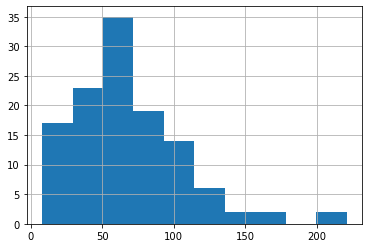

In [34]:
trial_data['word_count_nltk'] = trial_data['words'].apply(len)
trial_data['word_count_nltk'].hist()

In [35]:
trial_data['I_count'] = trial_data['transcript'].str.count('I ')
trial_data['I_count']

0       3
1       8
2       1
3       2
4      11
       ..
115     4
116     9
117     6
118     2
119     2
Name: I_count, Length: 120, dtype: int64

In [36]:
nltk_sentiment = SentimentIntensityAnalyzer()

In [37]:
full_sent = trial_data['transcript'].apply(lambda x: nltk_sentiment.polarity_scores(x))
full_sent.head()

0    {'neg': 0.398, 'neu': 0.602, 'pos': 0.0, 'comp...
1    {'neg': 0.012, 'neu': 0.965, 'pos': 0.024, 'co...
2    {'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'comp...
3    {'neg': 0.154, 'neu': 0.8, 'pos': 0.046, 'comp...
4    {'neg': 0.145, 'neu': 0.749, 'pos': 0.106, 'co...
Name: transcript, dtype: object

In [39]:
# store the compound sentiment in a column
trial_data['sentiment'] = full_sent.apply(lambda x: x['compound'])
print(trial_data['sentiment'].head())

0   -0.6808
1    0.3612
2   -0.2960
3   -0.6964
4   -0.8829
Name: sentiment, dtype: float64


<AxesSubplot:>

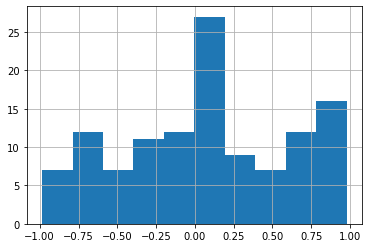

In [40]:
trial_data['sentiment'].hist()

In [41]:
pred_vars = ['word_count_nltk', 'sentiment', 'I_count']

# define the dependent variable
outcome = 'condition'

In [42]:
np.random.seed(516)

# create train and test
train, test = train_test_split(trial_data, test_size=0.20, stratify=trial_data[outcome])
print("Rows in train:", len(train))
print("Rows in test:", len(test))

Rows in train: 96
Rows in test: 24


In [43]:
#%% random forest
params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, None]}

rf_tuned = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc')
rf_tuned.fit(train[pred_vars], train[outcome])


#%% Multi-layer Perceptron
params = {'hidden_layer_sizes': [(100,), (10,10), (5,5,5)], 
          'solver': ['adam', 'lbfgs', 'sgd']}

nnet_tuned = GridSearchCV(MLPClassifier(), param_grid=params, scoring='roc_auc')
nnet_tuned.fit(train[pred_vars], train[outcome])

#%% adaboost
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

params = {'n_estimators': [10, 25, 50]}

ada_tuned = GridSearchCV(AdaBoostClassifier(), param_grid=params, scoring='roc_auc')
ada_tuned.fit(train[pred_vars], train[outcome])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochas

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [10, 25, 50]}, scoring='roc_auc')

RandomForestClassifier()
MLPClassifier()
AdaBoostClassifier()


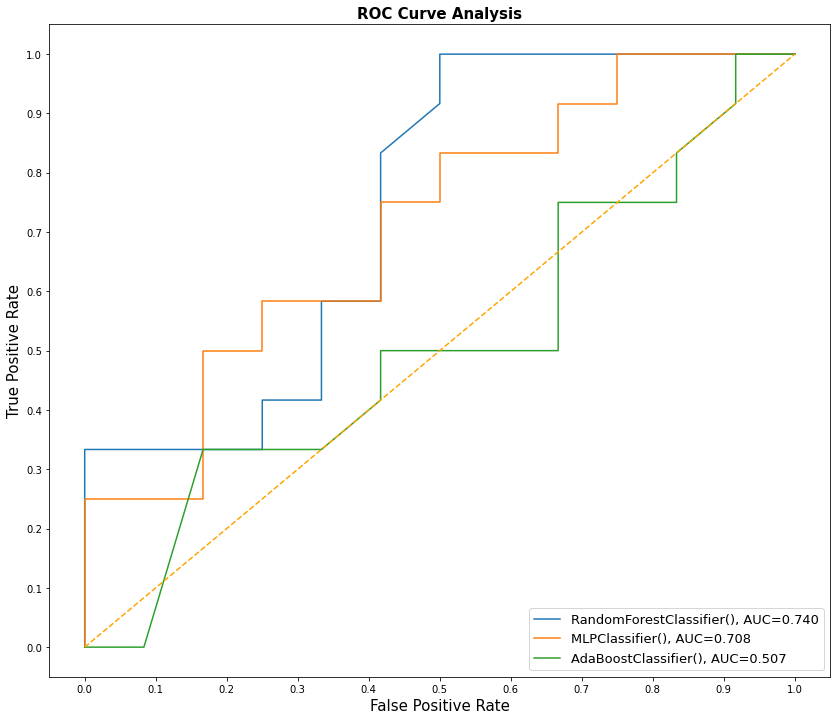

In [44]:
fitted = [rf_tuned, nnet_tuned, ada_tuned]

result_table = pd.DataFrame(columns=['classifier_name', 'fpr','tpr','auc', 
                                     'log_loss', 'clf_report'])

for clf in fitted:
    print(clf.estimator)
    yproba = clf.predict_proba(test[pred_vars])
    yclass = clf.predict(test[pred_vars])
    
    # auc information
    """
    Note that I specified the positve case here as 'truth'
    since that is what we are trying to detect. Otherwise,
    this line will present an error, since the classes are not
    0 or 1, but categorical labels.
    """
    fpr, tpr, _ = metrics.roc_curve(test[outcome],  yproba[:,1], pos_label='truth')
    auc = metrics.roc_auc_score(test[outcome], yproba[:,1])
    
    # log loss
    log_loss = metrics.log_loss(test[outcome], yproba[:,1])
    
    # add some other stats based on confusion matrix
    clf_report = metrics.classification_report(test[outcome], yclass)
    
    
    result_table = result_table.append({'classifier_name':str(clf.estimator),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'log_loss': log_loss,
                                        'clf_report': clf_report}, ignore_index=True)
    


result_table.set_index('classifier_name', inplace=True)
# print(result_table)



fig = plt.figure(figsize=(14,12))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [45]:
for i in result_table.index:
    print('\n---- statistics for', i, "----\n")
    print(result_table.loc[i, 'clf_report'])
    print("Model log loss:", result_table.loc[i, 'log_loss'])


---- statistics for RandomForestClassifier() ----

              precision    recall  f1-score   support

         lie       0.64      0.58      0.61        12
       truth       0.62      0.67      0.64        12

    accuracy                           0.62        24
   macro avg       0.63      0.62      0.62        24
weighted avg       0.63      0.62      0.62        24

Model log loss: 0.5786251311993914

---- statistics for MLPClassifier() ----

              precision    recall  f1-score   support

         lie       0.62      0.83      0.71        12
       truth       0.75      0.50      0.60        12

    accuracy                           0.67        24
   macro avg       0.69      0.67      0.66        24
weighted avg       0.69      0.67      0.66        24

Model log loss: 0.6515220593365888

---- statistics for AdaBoostClassifier() ----

              precision    recall  f1-score   support

         lie       0.45      0.42      0.43        12
       truth       0.46 

Adding the number of I's said in each transcipt made the models worse except for the the Random Forest Model.